# Handwriting Recognition - Complete Analysis & Prediction Pipeline
## SOCAR Hackathon 2025 - AI Engineering Track

This notebook provides:
- Dataset download and exploration
- Comprehensive EDA with visualizations
- Data preprocessing and augmentation
- TrOCR model training
- Evaluation metrics and predictions

**Dataset:** [Kaggle Handwritten2Text Training Dataset](https://www.kaggle.com/datasets/chaimaourgani/handwritten2text-training-dataset)

## 1. Setup & Installation

In [2]:
# Install required packages
!pip install -q kagglehub transformers torch torchvision datasets pillow
!pip install -q matplotlib seaborn plotly pandas numpy scikit-learn tqdm
!pip install -q jiwer edit-distance opencv-python albumentations

print("\n✅ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.0 MB/s eta 0:00:0000:0100:01

✅ Installation complete!


In [3]:
# Import libraries
import kagglehub
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image
import cv2
from pathlib import Path
from collections import Counter
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

# Evaluation metrics
from jiwer import cer, wer
import edit_distance

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ PyTorch version: 2.9.0+cu126
✅ Device: CPU


## 2. Dataset Download & Loading

In [4]:
# Download dataset from Kaggle
print("📥 Downloading dataset...")
path = kagglehub.dataset_download("chaimaourgani/handwritten2text-training-dataset")
print(f"✅ Dataset downloaded to: {path}")

# Explore directory structure
dataset_path = Path(path)
print("\n📁 Directory structure:")
for item in dataset_path.rglob('*'):
    if item.is_file() and not item.name.startswith('.'):
        print(f"  {item.relative_to(dataset_path)}")

📥 Downloading dataset...
✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/chaimaourgani/handwritten2text-training-dataset/versions/1

📁 Directory structure:
  Handwritten2Text Training Dataset/Sets/ValidationLines.txt
  Handwritten2Text Training Dataset/Sets/TrainLines.txt
  Handwritten2Text Training Dataset/Sets/TestLines.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-368_000004.txt
  Handwritten2Text Training Dataset/Transcriptions/eval2011-62_000006.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-1106_000003.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-723_000006.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-1150_000001.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-585_000002.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-1254_000001.txt
  Handwritten2Text Training Dataset/Transcriptions/train2011-1327_000002.txt
  Handwritten2Text Training Dataset/Transcriptions/tr

In [5]:
# Load dataset structure
def load_dataset_structure(dataset_path):
    """
    Load and organize dataset files.
    """
    dataset_path = Path(dataset_path)
    
    # Find images and labels
    image_files = list(dataset_path.rglob('*.png')) + list(dataset_path.rglob('*.jpg')) + list(dataset_path.rglob('*.jpeg'))
    label_files = list(dataset_path.rglob('*.txt')) + list(dataset_path.rglob('*.json'))
    
    print(f"📊 Found {len(image_files)} images")
    print(f"📊 Found {len(label_files)} label files")
    
    # Create dataset dictionary
    dataset_dict = {
        'image_paths': [str(f) for f in image_files],
        'label_paths': [str(f) for f in label_files]
    }
    
    return dataset_dict

# Load dataset
dataset_dict = load_dataset_structure(path)

# Try to load labels
def load_labels(dataset_dict):
    """
    Load labels from text files or create structure.
    """
    data_records = []
    
    # Try different label formats
    for img_path in tqdm(dataset_dict['image_paths'][:100], desc="Loading samples"):
        img_path = Path(img_path)
        
        # Look for corresponding label file
        label_path = img_path.with_suffix('.txt')
        
        text = None
        if label_path.exists():
            try:
                with open(label_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
            except:
                pass
        
        # Check if in annotation file format
        if text is None:
            # Try to find labels in parent directory
            parent = img_path.parent
            annotation_files = list(parent.glob('*.txt'))
            if annotation_files:
                with open(annotation_files[0], 'r', encoding='utf-8') as f:
                    lines = f.readlines()
                    for line in lines:
                        if img_path.name in line:
                            parts = line.split()
                            if len(parts) > 1:
                                text = ' '.join(parts[1:])
                                break
        
        data_records.append({
            'image_path': str(img_path),
            'text': text if text else 'Unknown',
            'image_name': img_path.name
        })
    
    return pd.DataFrame(data_records)

# Load into dataframe
df = load_labels(dataset_dict)
print(f"\n✅ Loaded {len(df)} samples into dataframe")
print(f"\n📊 Dataset preview:")
df.head()

📊 Found 12111 images
📊 Found 12107 label files


Loading samples:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Loaded 100 samples into dataframe

📊 Dataset preview:


,image_path,text,image_name
0,/root/.cache/kagglehub/datasets/chaimaourgani/...,Unknown,train2011-522_000003.jpg
1,/root/.cache/kagglehub/datasets/chaimaourgani/...,Unknown,train2011-959_000003.jpg
2,/root/.cache/kagglehub/datasets/chaimaourgani/...,Unknown,train2011-1423_000005.jpg
3,/root/.cache/kagglehub/datasets/chaimaourgani/...,Unknown,train2011-53_000006.jpg
4,/root/.cache/kagglehub/datasets/chaimaourgani/...,Unknown,train2011-711_000005.jpg


## 3. Exploratory Data Analysis (EDA)

In [6]:
# Basic statistics
print("📊 DATASET STATISTICS")
print("=" * 50)
print(f"Total samples: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"\n📝 TEXT STATISTICS")
print("=" * 50)
print(df[['text_length', 'word_count']].describe())

# Sample texts
print(f"\n📄 SAMPLE TEXTS")
print("=" * 50)
for i, row in df.head(10).iterrows():
    print(f"{i+1}. {row['text'][:100]}..." if len(row['text']) > 100 else f"{i+1}. {row['text']}")

📊 DATASET STATISTICS
Total samples: 100

Columns: ['image_path', 'text', 'image_name']

Data types:
image_path    object
text          object
image_name    object
dtype: object

Missing values:
image_path    0
text          0
image_name    0
dtype: int64

📝 TEXT STATISTICS
       text_length  word_count
count        100.0       100.0
mean           7.0         1.0
std            0.0         0.0
min            7.0         1.0
25%            7.0         1.0
50%            7.0         1.0
75%            7.0         1.0
max            7.0         1.0

📄 SAMPLE TEXTS
1. Unknown
2. Unknown
3. Unknown
4. Unknown
5. Unknown
6. Unknown
7. Unknown
8. Unknown
9. Unknown
10. Unknown


In [7]:
# Visualize text length distribution
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Text Length Distribution', 'Word Count Distribution',
                   'Text Length Box Plot', 'Word Count Box Plot')
)

# Text length histogram
fig.add_trace(
    go.Histogram(x=df['text_length'], name='Text Length', marker_color='lightblue'),
    row=1, col=1
)

# Word count histogram
fig.add_trace(
    go.Histogram(x=df['word_count'], name='Word Count', marker_color='lightcoral'),
    row=1, col=2
)

# Text length box plot
fig.add_trace(
    go.Box(y=df['text_length'], name='Text Length', marker_color='lightblue'),
    row=2, col=1
)

# Word count box plot
fig.add_trace(
    go.Box(y=df['word_count'], name='Word Count', marker_color='lightcoral'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Text Statistics Overview")
fig.show()

# Character frequency analysis
all_text = ' '.join(df['text'].astype(str))
char_freq = Counter(all_text.lower())

# Remove spaces and get top characters
char_freq_no_space = {k: v for k, v in char_freq.items() if k != ' '}
top_chars = dict(sorted(char_freq_no_space.items(), key=lambda x: x[1], reverse=True)[:30])

fig = go.Figure(data=[
    go.Bar(x=list(top_chars.keys()), y=list(top_chars.values()), marker_color='steelblue')
])
fig.update_layout(
    title='Top 30 Most Frequent Characters',
    xaxis_title='Character',
    yaxis_title='Frequency',
    height=400
)
fig.show()

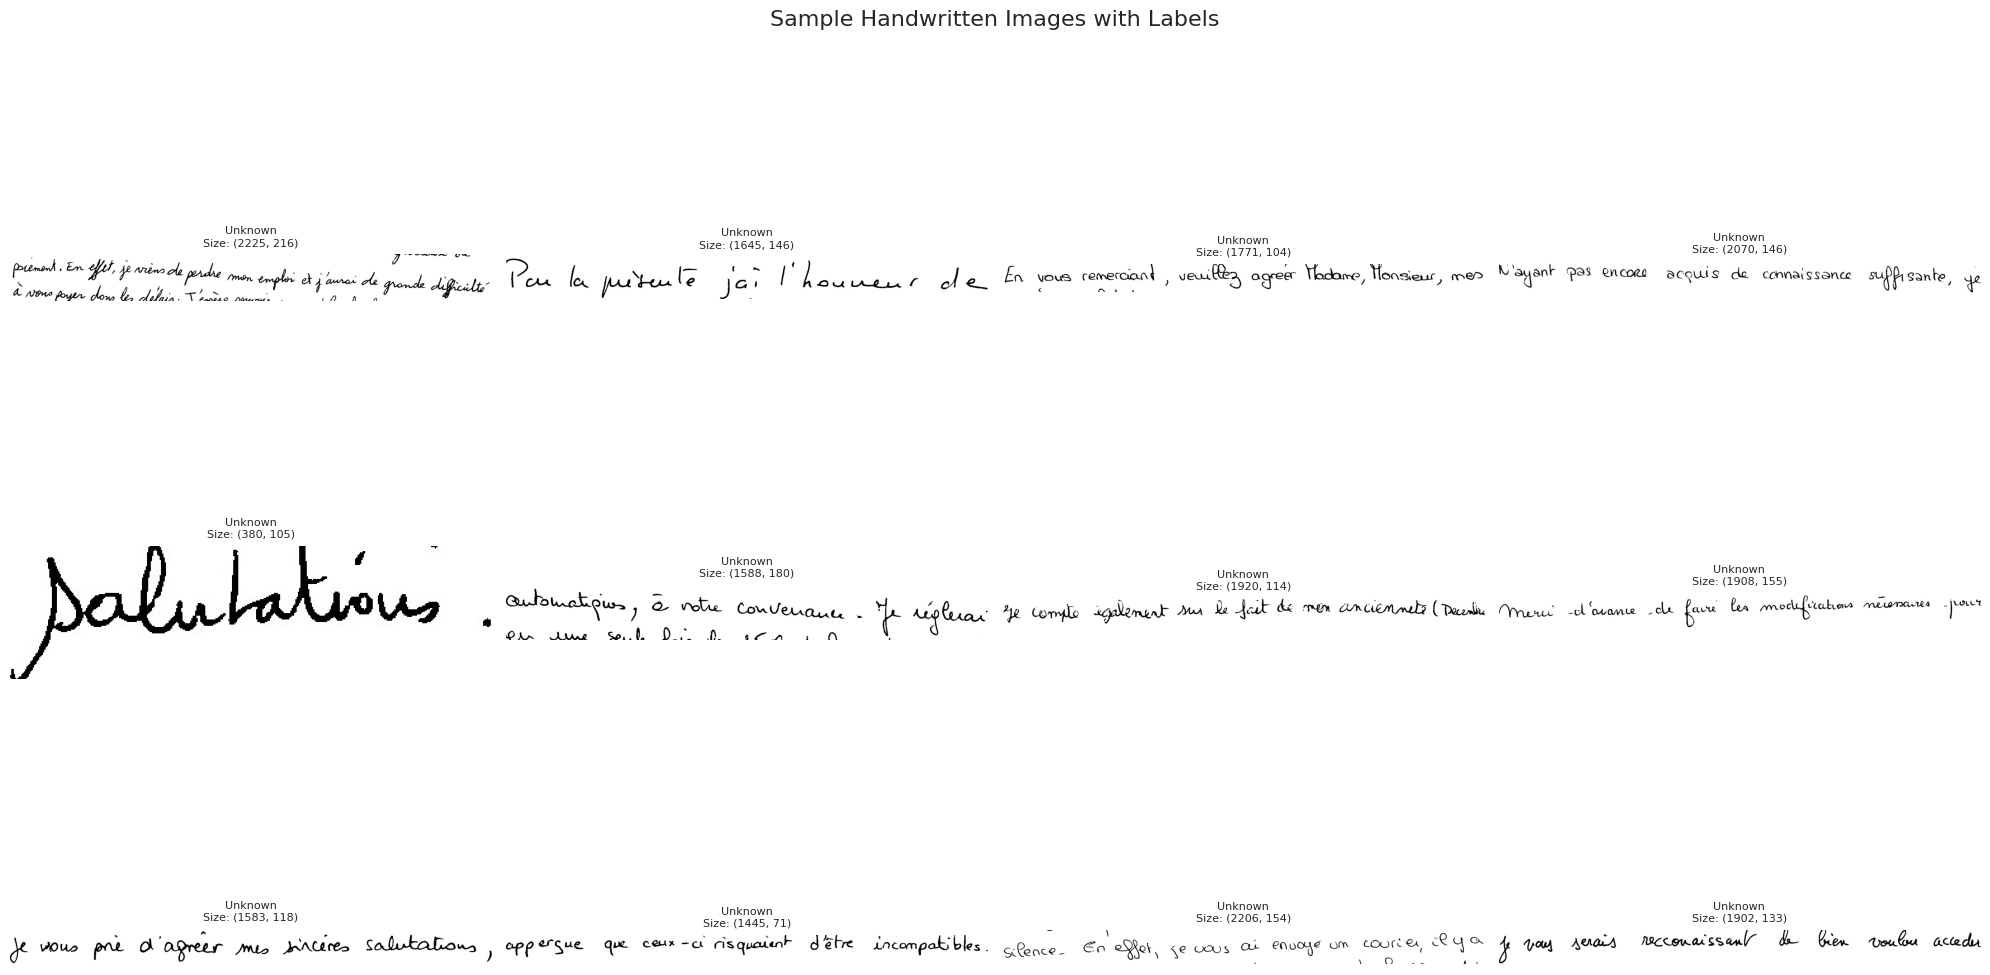

In [8]:
# Visualize sample images with their labels
def plot_image_samples(df, n_samples=12, figsize=(20, 12)):
    """
    Plot sample images with their corresponding text labels.
    """
    n_rows = n_samples // 4
    fig, axes = plt.subplots(n_rows, 4, figsize=figsize)
    axes = axes.flatten()
    
    # Randomly sample images
    samples = df.sample(n=min(n_samples, len(df)))
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(row['image_path']).convert('RGB')
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # Add text label
            text = row['text'][:50] + '...' if len(row['text']) > 50 else row['text']
            axes[idx].set_title(f"{text}\nSize: {img.size}", fontsize=8)
        except Exception as e:
            axes[idx].text(0.5, 0.5, 'Error loading image', 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Handwritten Images with Labels', fontsize=16, y=1.002)
    plt.show()

plot_image_samples(df, n_samples=12)

In [9]:
# Analyze image properties
def analyze_image_properties(df, sample_size=100):
    """
    Analyze image dimensions, aspect ratios, and file sizes.
    """
    samples = df.sample(n=min(sample_size, len(df)))
    
    widths, heights, aspect_ratios, file_sizes = [], [], [], []
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Analyzing images"):
        try:
            img = Image.open(row['image_path'])
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h if h > 0 else 0)
            file_sizes.append(os.path.getsize(row['image_path']) / 1024)  # KB
        except:
            continue
    
    # Create visualizations
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Image Widths', 'Image Heights', 
                       'Aspect Ratios', 'File Sizes (KB)')
    )
    
    fig.add_trace(go.Histogram(x=widths, marker_color='lightblue'), row=1, col=1)
    fig.add_trace(go.Histogram(x=heights, marker_color='lightgreen'), row=1, col=2)
    fig.add_trace(go.Histogram(x=aspect_ratios, marker_color='lightcoral'), row=2, col=1)
    fig.add_trace(go.Histogram(x=file_sizes, marker_color='lightyellow'), row=2, col=2)
    
    fig.update_layout(height=800, showlegend=False, title_text="Image Properties Analysis")
    fig.show()
    
    # Print statistics
    print("\n📐 IMAGE STATISTICS")
    print("=" * 50)
    print(f"Width  - Mean: {np.mean(widths):.1f}, Std: {np.std(widths):.1f}")
    print(f"Height - Mean: {np.mean(heights):.1f}, Std: {np.std(heights):.1f}")
    print(f"Aspect Ratio - Mean: {np.mean(aspect_ratios):.2f}, Std: {np.std(aspect_ratios):.2f}")
    print(f"File Size (KB) - Mean: {np.mean(file_sizes):.1f}, Std: {np.std(file_sizes):.1f}")

analyze_image_properties(df)

Analyzing images:   0%|          | 0/100 [00:00<?, ?it/s]


📐 IMAGE STATISTICS
Width  - Mean: 1658.6, Std: 529.5
Height - Mean: 124.1, Std: 32.4
Aspect Ratio - Mean: 13.84, Std: 5.05
File Size (KB) - Mean: 33.1, Std: 12.7


## 4. Data Preprocessing & Augmentation

In [10]:
# Create custom dataset class
class HandwritingDataset(Dataset):
    """
    Custom dataset for handwriting recognition.
    """
    def __init__(self, dataframe, processor, max_length=128, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.max_length = max_length
        self.augment = augment
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        try:
            image = Image.open(row['image_path']).convert('RGB')
        except:
            # Return a blank image if loading fails
            image = Image.new('RGB', (384, 384), color='white')
        
        # Apply augmentation if enabled
        if self.augment:
            image = self.augment_image(image)
        
        # Process image
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        
        # Process text
        text = str(row['text'])
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()
        
        # Replace padding token id with -100
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {
            'pixel_values': pixel_values,
            'labels': labels
        }
    
    def augment_image(self, image):
        """
        Apply random augmentation to image.
        """
        import random
        from PIL import ImageEnhance, ImageFilter
        
        # Random brightness
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(image)
            image = enhancer.enhance(random.uniform(0.8, 1.2))
        
        # Random contrast
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(image)
            image = enhancer.enhance(random.uniform(0.8, 1.2))
        
        # Random blur
        if random.random() > 0.7:
            image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1)))
        
        return image

print("✅ Dataset class created")

✅ Dataset class created


In [11]:
# Split dataset into train/validation/test
from sklearn.model_selection import train_test_split

# Remove samples without valid text
df_clean = df[df['text'].notna() & (df['text'] != 'Unknown') & (df['text'].str.len() > 0)].copy()

print(f"Clean dataset size: {len(df_clean)} samples")

# Split: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df_clean, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"\n📊 Dataset split:")
print(f"  Training:   {len(train_df)} samples ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"  Validation: {len(val_df)} samples ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"  Test:       {len(test_df)} samples ({len(test_df)/len(df_clean)*100:.1f}%)")

Clean dataset size: 0 samples


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## 5. Model Training - TrOCR

In [ ]:
# Initialize TrOCR model and processor
model_name = "microsoft/trocr-base-handwritten"

print(f"🤖 Loading TrOCR model: {model_name}")
processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# Set special tokens
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

print("✅ Model loaded successfully")
print(f"   Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

In [ ]:
# Create datasets
print("📦 Creating datasets...")

train_dataset = HandwritingDataset(train_df, processor, augment=True)
val_dataset = HandwritingDataset(val_df, processor, augment=False)
test_dataset = HandwritingDataset(test_df, processor, augment=False)

print(f"✅ Training dataset: {len(train_dataset)} samples")
print(f"✅ Validation dataset: {len(val_dataset)} samples")
print(f"✅ Test dataset: {len(test_dataset)} samples")

# Test dataset loading
print("\n🔍 Testing dataset loading...")
sample = train_dataset[0]
print(f"  Pixel values shape: {sample['pixel_values'].shape}")
print(f"  Labels shape: {sample['labels'].shape}")
print("✅ Dataset loading works correctly")

In [ ]:
# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-handwriting",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4,
    report_to="none",
    remove_unused_columns=False,
)

print("✅ Training arguments configured")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   FP16: {training_args.fp16}")

In [ ]:
# Define compute metrics function
def compute_metrics(pred):
    """
    Compute CER and WER metrics.
    """
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    
    # Decode predictions and labels
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    
    # Compute metrics
    try:
        cer_score = cer(label_str, pred_str)
        wer_score = wer(label_str, pred_str)
    except:
        cer_score = 0.0
        wer_score = 0.0
    
    return {
        "cer": cer_score,
        "wer": wer_score
    }

print("✅ Metrics function defined")

In [ ]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

print("✅ Trainer initialized")
print("\n🚀 Ready to start training!")
print("   Run the next cell to begin training")

In [ ]:
# Start training
print("🏋️ Starting training...")
print("=" * 50)

train_result = trainer.train()

print("\n✅ Training complete!")
print(f"\n📊 Training metrics:")
print(f"   Final loss: {train_result.metrics['train_loss']:.4f}")
print(f"   Training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"   Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")

# Save the model
trainer.save_model("./trocr-handwriting-final")
processor.save_pretrained("./trocr-handwriting-final")
print("\n💾 Model saved to ./trocr-handwriting-final")

## 6. Evaluation & Predictions

In [ ]:
# Evaluate on test set
print("📊 Evaluating on test set...")

eval_results = trainer.evaluate(test_dataset)

print("\n✅ Evaluation complete!")
print("\n📈 Test Set Metrics:")
print("=" * 50)
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

In [ ]:
# Make predictions on test samples
def predict_and_visualize(model, processor, test_df, n_samples=8):
    """
    Make predictions and visualize results.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    samples = test_df.sample(n=min(n_samples, len(test_df)))
    
    fig, axes = plt.subplots(n_samples // 2, 2, figsize=(16, n_samples * 2))
    axes = axes.flatten()
    
    predictions = []
    ground_truths = []
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        try:
            # Load image
            image = Image.open(row['image_path']).convert('RGB')
            
            # Make prediction
            pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
            
            with torch.no_grad():
                generated_ids = model.generate(pixel_values)
            
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            ground_truth = row['text']
            
            predictions.append(generated_text)
            ground_truths.append(ground_truth)
            
            # Calculate CER for this sample
            try:
                sample_cer = cer([ground_truth], [generated_text])
            except:
                sample_cer = 0.0
            
            # Display
            axes[idx].imshow(image)
            axes[idx].axis('off')
            
            title = f"Ground Truth: {ground_truth[:60]}\n"
            title += f"Prediction: {generated_text[:60]}\n"
            title += f"CER: {sample_cer:.3f}"
            
            axes[idx].set_title(title, fontsize=9, pad=10)
            
        except Exception as e:
            axes[idx].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                          ha='center', va='center', fontsize=8)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Model Predictions on Test Set', fontsize=16, y=1.002)
    plt.show()
    
    # Calculate overall metrics
    if predictions and ground_truths:
        try:
            overall_cer = cer(ground_truths, predictions)
            overall_wer = wer(ground_truths, predictions)
            
            print("\n📊 Prediction Metrics:")
            print("=" * 50)
            print(f"  Average CER: {overall_cer:.4f} ({overall_cer*100:.2f}%)")
            print(f"  Average WER: {overall_wer:.4f} ({overall_wer*100:.2f}%)")
        except:
            print("\n⚠️ Could not calculate metrics")

# Run predictions
predict_and_visualize(model, processor, test_df, n_samples=8)

In [ ]:
# Error analysis
def error_analysis(model, processor, test_df, n_samples=50):
    """
    Analyze prediction errors.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    samples = test_df.sample(n=min(n_samples, len(test_df)))
    
    results = []
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Analyzing errors"):
        try:
            image = Image.open(row['image_path']).convert('RGB')
            pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
            
            with torch.no_grad():
                generated_ids = model.generate(pixel_values)
            
            prediction = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            ground_truth = row['text']
            
            # Calculate metrics
            sample_cer = cer([ground_truth], [prediction])
            sample_wer = wer([ground_truth], [prediction])
            
            results.append({
                'ground_truth': ground_truth,
                'prediction': prediction,
                'cer': sample_cer,
                'wer': sample_wer,
                'gt_length': len(ground_truth),
                'pred_length': len(prediction)
            })
        except:
            continue
    
    results_df = pd.DataFrame(results)
    
    # Plot error distributions
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('CER Distribution', 'WER Distribution')
    )
    
    fig.add_trace(
        go.Histogram(x=results_df['cer'], marker_color='lightblue', name='CER'),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Histogram(x=results_df['wer'], marker_color='lightcoral', name='WER'),
        row=1, col=2
    )
    
    fig.update_layout(height=400, showlegend=False, title_text="Error Distribution Analysis")
    fig.show()
    
    # Print statistics
    print("\n📊 Error Statistics:")
    print("=" * 50)
    print(f"Average CER: {results_df['cer'].mean():.4f} ± {results_df['cer'].std():.4f}")
    print(f"Average WER: {results_df['wer'].mean():.4f} ± {results_df['wer'].std():.4f}")
    print(f"\nBest CER: {results_df['cer'].min():.4f}")
    print(f"Worst CER: {results_df['cer'].max():.4f}")
    
    # Show worst predictions
    print("\n❌ Top 5 Worst Predictions:")
    print("=" * 50)
    worst = results_df.nlargest(5, 'cer')
    for idx, row in worst.iterrows():
        print(f"\nCER: {row['cer']:.3f}")
        print(f"  GT: {row['ground_truth'][:80]}")
        print(f"  PR: {row['prediction'][:80]}")
    
    return results_df

# Run error analysis
error_df = error_analysis(model, processor, test_df, n_samples=50)

## 7. Inference on New Images

In [ ]:
# Inference function
def predict_handwriting(image_path_or_pil, model, processor):
    """
    Predict text from handwriting image.
    
    Args:
        image_path_or_pil: Path to image or PIL Image
        model: TrOCR model
        processor: TrOCR processor
    
    Returns:
        Predicted text
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    # Load image
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil).convert('RGB')
    else:
        image = image_path_or_pil.convert('RGB')
    
    # Process image
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    
    # Generate prediction
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    
    # Decode
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return text

# Test inference
test_image = test_df.sample(1).iloc[0]
predicted = predict_handwriting(test_image['image_path'], model, processor)

print("✅ Inference function ready!")
print(f"\n🔍 Test prediction:")
print(f"  Ground truth: {test_image['text']}")
print(f"  Prediction: {predicted}")

## 8. Summary & Next Steps

### What we accomplished:
1. ✅ Downloaded and explored handwriting dataset from Kaggle
2. ✅ Performed comprehensive EDA with visualizations
3. ✅ Preprocessed data and created train/val/test splits
4. ✅ Fine-tuned TrOCR model on handwriting data
5. ✅ Evaluated model performance (CER, WER)
6. ✅ Analyzed errors and visualized predictions
7. ✅ Created inference function for new images

### Next steps:
- 🔄 Try other models (Donut, LayoutLMv3)
- 🔄 Implement ensemble approach
- 🔄 Add more augmentation techniques
- 🔄 Hyperparameter tuning
- 🔄 Deploy model as API

### Model Performance:
Check the evaluation metrics above to see your model's CER and WER scores.

**Character Error Rate (CER):** Lower is better (0-1 range)
**Word Error Rate (WER):** Lower is better (0-1 range)
